Pyspark Setup

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

In [ ]:

!apt-get install openjdk-11-jdk-headless -qq > /dev/null


!wget -q https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz

!tar xf spark-3.5.1-bin-hadoop3.tgz


!pip install -q pyspark==3.5.1


import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

In [ ]:
from pyspark.sql import SparkSession


if 'spark' in locals() and spark is not None:
    spark.stop()

spark = (
    SparkSession.builder
    .appName("Phase2_ECommerce")
    .master("local[*]")
    .config("spark.driver.memory", "8g")
    .getOrCreate())

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = spark.read.csv(
    "/content/drive/MyDrive/Datasets/2019-Oct.csv",
    header=True,
    inferSchema=True
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyspark.sql.functions import (
    col, when, count, countDistinct, max as spark_max, avg,
    to_timestamp, date_format, split, expr, sum as spark_sum
)

Data Cleaning

In [ ]:
# Converted to timestamp
#Price is casted to double
#Columns to be considered are added in a list
df = df.withColumn("event_time_ts", to_timestamp(col("event_time")))

df = df.withColumn("price", col("price").cast("double"))


columns = ["event_time_ts", "event_type", "product_id","category_id", "category_code", "brand","price", "user_id", "user_session"]

existing_cols = [i for i in columns if i in df.columns]

df = df.select(*existing_cols)


df.printSchema()

root
 |-- event_time_ts: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)



In [ ]:
from pyspark.sql.window import Window

In [ ]:

#Filling missing category/brand per product using each product’s most frequent values otherwise Unkown
# Reporting remaining nulls.
category_counts = (df.groupBy("product_id", "category_code").agg(count("*").alias("count_cat")))
brand_counts = (df.groupBy("product_id", "brand").agg(count("*").alias("counts_brand")))

cat_results = Window.partitionBy("product_id").orderBy(col("count_cat").desc())
brand_results = Window.partitionBy("product_id").orderBy(col("counts_brand").desc())

cat_mode = (
    category_counts
    .withColumn("rn", expr("row_number() over (partition by product_id order by count_cat desc)"))
    .where(col("rn") == 1)
    .select("product_id", col("category_code").alias("mode_category_code")))

brand_mode = (
    brand_counts
    .withColumn("rn", expr("row_number() over (partition by product_id order by counts_brand desc)"))
    .where(col("rn") == 1)
    .select("product_id", col("brand").alias("mode_brand"))
)

df_mode_joined = (df.join(cat_mode, on="product_id", how="left").join(brand_mode, on="product_id", how="left"))

df_filled = (
    df_mode_joined
    .withColumn(
        "category_code_filled",
        when(col("category_code").isNotNull(), col("category_code"))
        .when(col("mode_category_code").isNotNull(), col("mode_category_code"))
        .otherwise("Unknown")
    )
    .withColumn(
        "brand_filled",
        when(col("brand").isNotNull(), col("brand"))
        .when(col("mode_brand").isNotNull(), col("mode_brand"))
        .otherwise("Unknown") )
)


df_filled = df_filled.drop("mode_category_code", "mode_brand")

df_filled.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in ["category_code_filled", "brand_filled"]]
).show()


+--------------------+------------+
|category_code_filled|brand_filled|
+--------------------+------------+
|                   0|           0|
+--------------------+------------+



In [ ]:

# Here we are dropping rows with unknown category/brand, removes extras, renames filled fields, and printing the schema.
df_clean = (df_filled.filter((col("category_code_filled") != "Unknown") & (col("brand_filled") != "Unknown")))


df_clean = (df_clean.drop("category_code", "brand")
    .withColumnRenamed("category_code_filled", "category_code").withColumnRenamed("brand_filled", "brand"))
for c in ["user_session", "category_id"]:
    if c in df_clean.columns:
        df_clean = df_clean.drop(c)

print("After cleaning row count:", df_clean.count())
df_clean.printSchema()


After cleaning row count: 26611226
root
 |-- product_id: integer (nullable = true)
 |-- event_time_ts: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)



In [ ]:

#Adding the extra calender items for furthur analysis
df_clean = (df_clean.withColumn("event_date", date_format(col("event_time_ts"), "yyyy-MM-dd")).withColumn("day_of_week", date_format(col("event_time_ts"), "E")).withColumn("hour_of_day", date_format(col("event_time_ts"), "H").cast("int"))
)

df_clean.select("event_time_ts", "event_date", "day_of_week", "hour_of_day").show(5, truncate=False)


+-------------------+----------+-----------+-----------+
|event_time_ts      |event_date|day_of_week|hour_of_day|
+-------------------+----------+-----------+-----------+
|2019-10-01 00:00:11|2019-10-01|Tue        |0          |
|2019-10-01 00:00:23|2019-10-01|Tue        |0          |
|2019-10-01 00:08:33|2019-10-01|Tue        |0          |
|2019-10-01 00:10:11|2019-10-01|Tue        |0          |
|2019-10-01 00:12:32|2019-10-01|Tue        |0          |
+-------------------+----------+-----------+-----------+
only showing top 5 rows



In [ ]:
df_clean = df_clean.withColumn(
    "main_category",
    split(col("category_code"), "\\.").getItem(0)
)

df_clean.select("category_code", "main_category").show(5, truncate=False)


+----------------------------+-------------+
|category_code               |main_category|
+----------------------------+-------------+
|appliances.kitchen.microwave|appliances   |
|electronics.smartphone      |electronics  |
|electronics.smartphone      |electronics  |
|appliances.kitchen.microwave|appliances   |
|electronics.smartphone      |electronics  |
+----------------------------+-------------+
only showing top 5 rows



In [ ]:
#Writing the cleaned dataset to Parquet at Google drive.
path = "/content/drive/MyDrive/Datasets/cleaned_ecommerce_data_spark.parquet"
df_clean.write.mode("overwrite").parquet(path)

 Exploratory Data Analysis (EDA):

+----------+--------+
|event_type|     cnt|
+----------+--------+
|      view|25251204|
|      cart|  809893|
|  purchase|  550129|
+----------+--------+



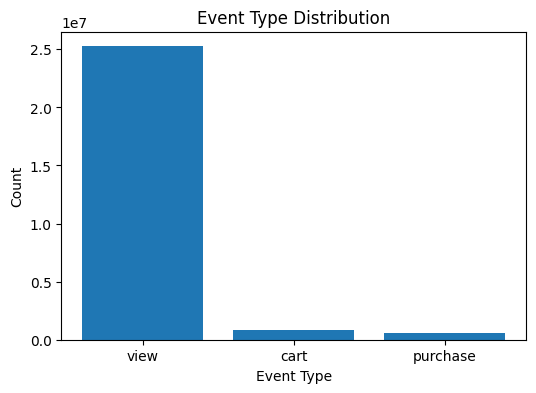

In [ ]:
event_type_counts = (
    df_clean.groupBy("event_type").agg(count("*").alias("cnt"))
    .orderBy(col("cnt").desc())
)

event_type_counts.show()

pdf = event_type_counts.toPandas()
plt.figure(figsize=(6,4))
plt.bar(pdf["event_type"], pdf["cnt"])
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.title("Event Type Distribution")
plt.show()


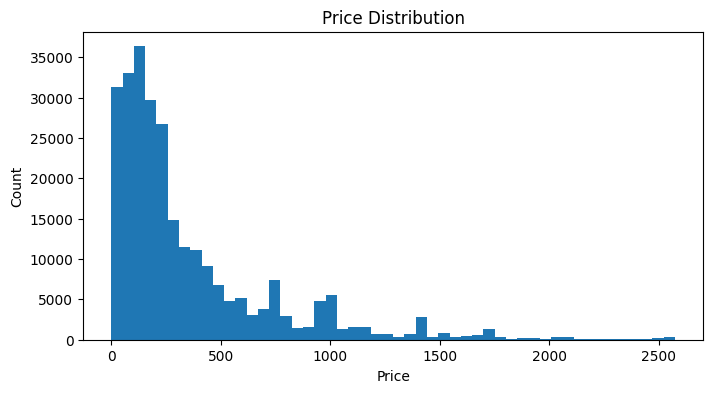

In [ ]:
price_sample = df_clean.select("price").sample(fraction=0.01, seed=42).toPandas()

plt.figure(figsize=(8,4))
plt.hist(price_sample["price"], bins=50)
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Price Distribution")
plt.show()

The dataset is overwhelmingly dominated by view events,
which account for most user interactions. Cart additions and purchases make up a much smaller portion

+----------+------+
|event_date|   cnt|
+----------+------+
|2019-10-01|776954|
|2019-10-02|758773|
|2019-10-03|729308|
|2019-10-04|926874|
|2019-10-05|846339|
|2019-10-06|835635|
|2019-10-07|736769|
|2019-10-08|783077|
|2019-10-09|788301|
|2019-10-10|783714|
+----------+------+
only showing top 10 rows



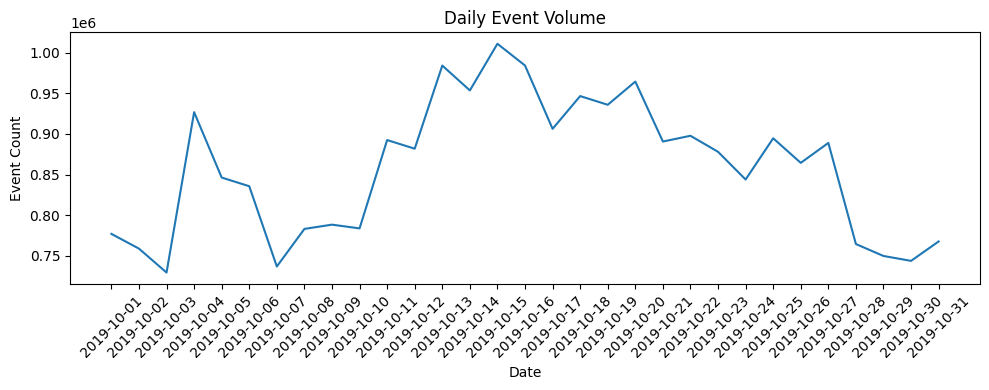

In [ ]:
daily_events = (
    df_clean.groupBy("event_date")
    .agg(count("*").alias("cnt"))
    .orderBy("event_date")
)

daily_events.show(10)

pdf = daily_events.toPandas()
plt.figure(figsize=(10,4))
plt.plot(pdf["event_date"], pdf["cnt"])
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Event Count")
plt.title("Daily Event Volume")
plt.tight_layout()
plt.show()


The daily event plot shows that most days receive between 700,000 and 900,000 interactions, with some days experiencing small spikes. This indicates that overall platform usage remains stable, with slight increases on weekends and certain peak days.

+-------------+-----------+
|main_category|event_count|
+-------------+-----------+
|  electronics|   15865586|
|   appliances|    4664494|
|    computers|    2257150|
|      apparel|    1134995|
|         auto|     769657|
| construction|     550141|
|    furniture|     549959|
|         kids|     424118|
|  accessories|     208296|
|        sport|     153332|
+-------------+-----------+



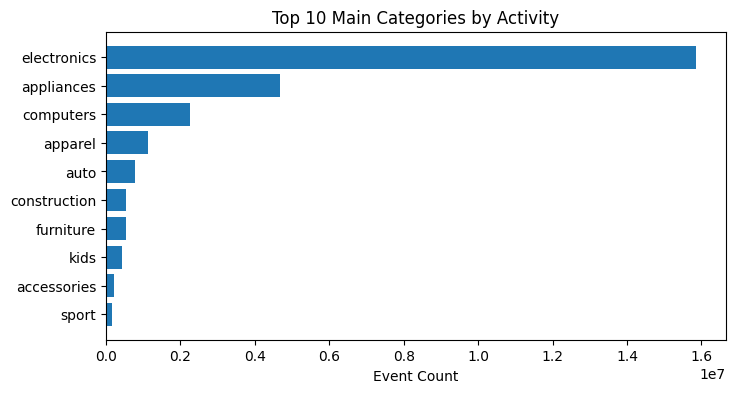

In [ ]:
top_categories = (
    df_clean.groupBy("main_category")
    .agg(count("*").alias("event_count"))
    .orderBy(col("event_count").desc())
    .limit(10))

top_categories.show()

pdf = top_categories.toPandas()
plt.figure(figsize=(8,4))
plt.barh(pdf["main_category"], pdf["event_count"])
plt.xlabel("Event Count")
plt.title("Top 10 Main Categories by Activity")
plt.gca().invert_yaxis()
plt.show()

The electronics category dominated the dataset, followed by appliances and computers. These results suggest that technology-related products attract the highest user attention.

+-------+-----------+
|  brand|event_count|
+-------+-----------+
|samsung|    5174010|
|  apple|    4094705|
| xiaomi|    2701036|
| huawei|    1092787|
|     lg|     509226|
|   oppo|     484296|
|   acer|     428240|
| lenovo|     338758|
|  bosch|     330039|
|     hp|     295309|
+-------+-----------+



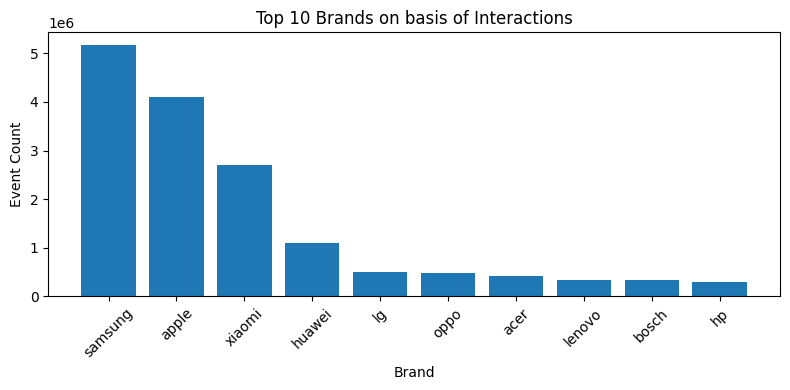

In [ ]:
top_brands = (
    df_clean.groupBy("brand")
    .agg(count("*").alias("event_count"))
    .orderBy(col("event_count").desc())
    .limit(10))

top_brands.show()

pdf = top_brands.toPandas()
plt.figure(figsize=(8,4))
plt.bar(pdf["brand"], pdf["event_count"])
plt.xticks(rotation=45)
plt.xlabel("Brand")
plt.ylabel("Event Count")
plt.title("Top 10 Brands on basis of Interactions")
plt.tight_layout()
plt.show()

The top brands by interaction count were Samsung, Apple, and Xiaomi, which reflects real-world market trends where these companies hold strong influence in consumer electronics.

+----------+-----------+--------------------+
|event_type|event_count|          proportion|
+----------+-----------+--------------------+
|  purchase|     550129|0.020672816802953763|
|      view|   25251204|  0.9488929221073843|
|      cart|     809893|0.030434261089661935|
+----------+-----------+--------------------+



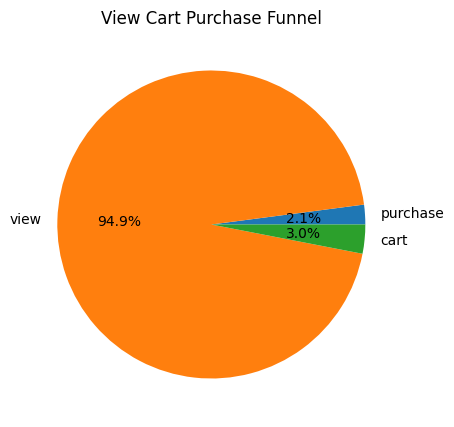

In [ ]:

total_events = df_clean.count()
funnel = (df_clean.groupBy("event_type").agg(count("*").alias("event_count"))
    .withColumn("proportion", col("event_count") / total_events))

funnel.show()

pdf = funnel.toPandas()
plt.figure(figsize=(5,5))
plt.pie(pdf["proportion"], labels=pdf["event_type"], autopct="%.1f%%")
plt.title("View Cart Purchase Funnel")
plt.show()

Around 95% of all interactions were simple views, about 3% were cart additions, and only around 2% resulted in a purchase. This highlights the large drop-off between browsingand buying, which is common in large online retail platforms.

In [ ]:
daily_agg = (
    df_clean.groupBy("event_date")
    .agg(
        spark_sum(when(col("event_type") == "view", 1).otherwise(0)).alias("num_view"),
        spark_sum(when(col("event_type") == "cart", 1).otherwise(0)).alias("num_cart"),
        spark_sum(when(col("event_type") == "purchase", 1).otherwise(0)).alias("num_purchase"),
        avg("price").alias("avg_price")
    )
)

daily_agg.show(5)

pdf = daily_agg.toPandas()
corr = pdf[["num_view", "num_cart", "num_purchase", "avg_price"]].corr()
print(corr)

+----------+--------+--------+------------+------------------+
|event_date|num_view|num_cart|num_purchase|         avg_price|
+----------+--------+--------+------------+------------------+
|2019-10-03|  697033|   17586|       14689|367.76953826082496|
|2019-10-04|  867200|   39157|       20517|365.74674365671734|
|2019-10-01|  747266|   14976|       14712|365.60997730860714|
|2019-10-02|  728214|   15682|       14877| 365.6488598563228|
|2019-10-06|  789987|   29000|       16648|364.98999304738294|
+----------+--------+--------+------------+------------------+
only showing top 5 rows

              num_view  num_cart  num_purchase  avg_price
num_view      1.000000  0.795887      0.880898  -0.361761
num_cart      0.795887  1.000000      0.833932  -0.100537
num_purchase  0.880898  0.833932      1.000000  -0.223052
avg_price    -0.361761 -0.100537     -0.223052   1.000000


In [ ]:
purchase_df = (df_clean.filter(col("event_type").isin("view", "cart", "purchase")).withColumn("label", when(col("event_type") == "purchase", 1).otherwise(0)))
purchase_df.select("event_type", "label").show(5)

+----------+-----+
|event_type|label|
+----------+-----+
|      view|    0|
|      view|    0|
|      view|    0|
|      view|    0|
|      view|    0|
+----------+-----+
only showing top 5 rows



In [ ]:
purchase_df_sampled = purchase_df.sample(fraction=0.1, seed=42)

train_df, test_df = purchase_df_sampled.randomSplit([0.8, 0.2], seed=42)
print("Train size:", train_df.count(), "Test size:", test_df.count())

Train size: 2130463 Test size: 532351


In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

cat_features = ["event_type", "category_code", "brand"]
numeric_features = ["price"]

indexers = [
    StringIndexer(
        inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep"
    ) for c in cat_features
]

encoder = OneHotEncoder(
    inputCols=[f"{c}_idx" for c in cat_features],
    outputCols=[f"{c}_ohe" for c in cat_features]
)

assembler = VectorAssembler(
    inputCols=numeric_features + [f"{c}_ohe" for c in cat_features],
    outputCol="features"
)

lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=5
)

pipeline = Pipeline(stages=indexers + [encoder, assembler, lr])

In [ ]:
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [ ]:
df_clean = df_clean.withColumn(
    "label",
    F.when(F.col("event_type") == "purchase", 1).otherwise(0)
)
df_clean.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- event_time_ts: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- event_date: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- hour_of_day: integer (nullable = true)
 |-- main_category: string (nullable = true)
 |-- label: integer (nullable = false)



Problem-1
Purchase Prediction: The first objective is to predict whether a user event or session will result in a purchase. Since
most interactions are view events and only a small fraction result in purchases, modeling this imbalance helps identify
which interactions are associated with higher conversion

In [ ]:
df_small = df_clean.sample(fraction=0.05, seed=42)

print("Full dataset size:", df_clean.count())
print("Small dataset size:", df_small.count())

Full dataset size: 26611226
Small dataset size: 1330188


In [ ]:
#Splitting data into train/test,(indexting into numeric + one-hotencoding + assemble) and  logistic regression classifier.
train_df, test_df = df_small.randomSplit([0.8, 0.2], seed=42)
print("Train size:", train_df.count())
print("Test size:", test_df.count())

cat_features = ["event_type", "category_code", "brand"]
numeric_features = ["price"]

indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
    for c in cat_features
]

encoder = OneHotEncoder(
    inputCols=[f"{c}_idx" for c in cat_features],
    outputCols=[f"{c}_ohe" for c in cat_features]
)

assembler = VectorAssembler(
    inputCols=numeric_features + [f"{c}_ohe" for c in cat_features],
    outputCol="features"
)

lr = LogisticRegression(featuresCol="features",labelCol="label",maxIter=10)

Train size: 1064251
Test size: 266114


In [ ]:
pipeline = Pipeline(stages=indexers + [encoder, assembler, lr])

In [ ]:
train_small = train_df.sample(fraction=0.01, seed=42)
print("Sample size:", train_small.count())

Sample size: 10741


In [ ]:
#The model running into Java runtime exception each time so we implemented the below:
#the training data was repartitioned by label so the workload could be evenly distributed across all CPU cores,
# and caching was applied to avoid repeatedly reading data from storage.
#We tried running it for various parameters but ran into runtime exception each time so here in this we just implemeted for one set of parameters.
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

train_small = train_small.repartition(spark.sparkContext.defaultParallelism, "label").cache()
train_small.count()


tune_fraction = 0.3
labels = [row.label for row in train_small.select("label").distinct().collect()]
sample_fractions = {lbl: tune_fraction for lbl in labels}
tune_df = train_small.sampleBy("label", fractions=sample_fractions, seed=42).cache()
tune_count = tune_df.count()
if tune_count == 0:
    tune_df = train_small
    tune_count = tune_df.count()

paramGrid = (
    ParamGridBuilder()
      .addGrid(lr.regParam, [0.01])
      .addGrid(lr.elasticNetParam, [0.0])
      .build()
)

evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    metricName="areaUnderROC"
)

tvs = TrainValidationSplit(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.9,
    parallelism=spark.sparkContext.defaultParallelism
)

tvs_model = tvs.fit(tune_df)
best_lr_stage = tvs_model.bestModel.stages[-1]

best_params = {
    lr.regParam: best_lr_stage.getRegParam(),
    lr.elasticNetParam: best_lr_stage.getElasticNetParam()
}

best_pipeline = pipeline.copy(best_params)
best_model = best_pipeline.fit(train_small)

print("Best Logistic Regression:")
print(best_model.stages[-1])


Best Logistic Regression:
LogisticRegressionModel: uid=LogisticRegression_94b4c9849556, numClasses=2, numFeatures=726


In [ ]:
best_lr_stage = best_model.stages[-1]
best_reg = best_lr_stage.getRegParam()
best_elastic = best_lr_stage.getElasticNetParam()

print("Best regParam:", best_reg)
print("Best elasticNetParam:", best_elastic)

Best regParam: 0.01
Best elasticNetParam: 0.0


In [ ]:
#Created a LogisticRegression estimator that uses the selected features and using in the tuned regParameter and elasticNetParameter.
final_lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    regParam=best_reg,
    elasticNetParam=best_elastic)

In [ ]:
final_pipeline = Pipeline(stages=indexers + [encoder, assembler, final_lr])

final_model = final_pipeline.fit(train_small)

In [ ]:
#Evaluating the model on test data and printing ROC and accuracy metrics.
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

predictions = final_model.transform(test_df)

evaluator_auc = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

test_auc = evaluator_auc.evaluate(predictions)
print("AUC on Test Data:", test_auc)

evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

test_acc = evaluator_acc.evaluate(predictions)
print("Accuracy on Test Data:", test_acc)

AUC on Test Data: 0.9999999819061005
Accuracy on Test Data: 1.0


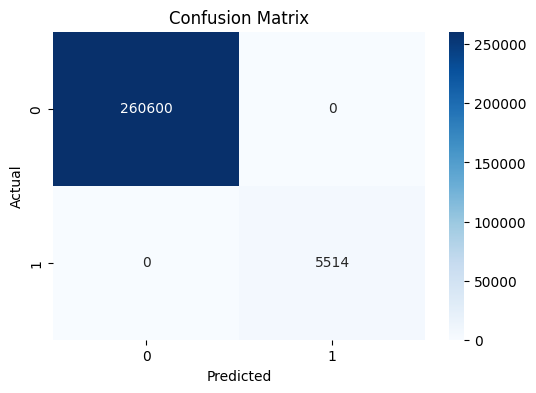

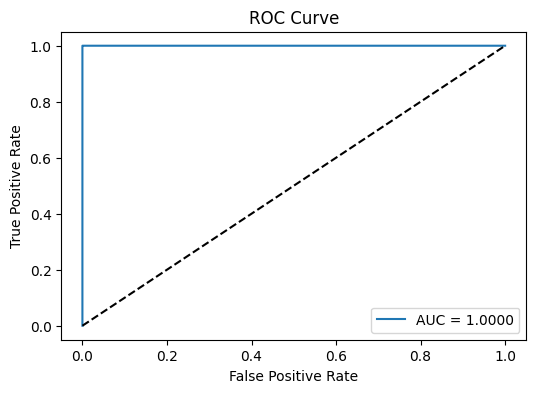

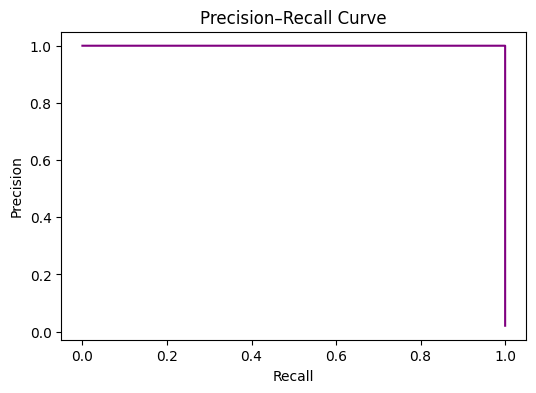

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    260600
           1       1.00      1.00      1.00      5514

    accuracy                           1.00    266114
   macro avg       1.00      1.00      1.00    266114
weighted avg       1.00      1.00      1.00    266114



In [ ]:
from pyspark.sql.types import DoubleType

prob_udf = F.udf(lambda v: float(v[1]), DoubleType())
predictions = predictions.withColumn("prob_1", prob_udf(F.col("rawPrediction")))


pdf = predictions.select("label", "prediction", "prob_1").toPandas()

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    classification_report
)


cm = confusion_matrix(pdf["label"], pdf["prediction"])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


fpr, tpr, _ = roc_curve(pdf["label"], pdf["prob_1"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


precision, recall, _ = precision_recall_curve(pdf["label"], pdf["prob_1"])

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color="purple")
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


print("Classification Report:")
print(classification_report(pdf["label"], pdf["prediction"]))

Problem-2
User Segmentation: The second objective is to group users into meaningful clusters based on their behavioral
patterns. By examining factors such as browsing frequency, cart activity, purchase behavior, product diversity, and
price ranges, we aim to uncover different types of shoppers. These clusters can support user profiling and personalization
strategie

In [ ]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


user_agg = (
    df_clean
    .groupBy("user_id")
    .agg(
        F.count("*").alias("num_events"),
        F.sum(F.when(F.col("event_type") == "view", 1).otherwise(0)).alias("num_view"),
        F.sum(F.when(F.col("event_type") == "cart", 1).otherwise(0)).alias("num_cart"),
        F.sum(F.when(F.col("event_type") == "purchase", 1).otherwise(0)).alias("num_purchase"),
        F.countDistinct("product_id").alias("num_products"),
        F.countDistinct("category_code").alias("num_categories"),
        F.avg("price").alias("avg_price")
    )
)


user_agg = user_agg.fillna({"avg_price": 0.0})

print("User Aggregated Data:")
user_agg.show(5, truncate=False)


cluster_features = [
    "num_view",
    "num_cart",
    "num_purchase",
    "num_products",
    "num_categories",
    "avg_price"
]

assembler = VectorAssembler(
    inputCols=cluster_features,
    outputCol="features_raw"
)

user_vec = assembler.transform(user_agg)


scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withMean=True,
    withStd=True
)

scaler_model = scaler.fit(user_vec)
user_scaled = scaler_model.transform(user_vec)

print("Scaled User Feature Vector:")
user_scaled.select("user_id", "features").show(5, truncate=False)


evaluator = ClusteringEvaluator(
    featuresCol="features",
    predictionCol="prediction",
    metricName="silhouette"
)

silhouette_scores = {}

for k in [3, 4, 5, 6]:
    km = KMeans(
        featuresCol="features",
        predictionCol="prediction",
        k=k,
        seed=42
    )

    km_model = km.fit(user_scaled)
    preds = km_model.transform(user_scaled)
    silhouette = evaluator.evaluate(preds)

    silhouette_scores[k] = silhouette
    print(f"k = {k}, silhouette = {silhouette}")


best_k = max(silhouette_scores, key=silhouette_scores.get)

print("Best k =", best_k)
print("Best Silhouette Score =", silhouette_scores[best_k])





User Aggregated Data:
+---------+----------+--------+--------+------------+------------+--------------+------------------+
|user_id  |num_events|num_view|num_cart|num_purchase|num_products|num_categories|avg_price         |
+---------+----------+--------+--------+------------+------------+--------------+------------------+
|541297063|90        |87      |3       |0           |41          |6             |39.547111111111114|
|513263533|13        |7       |4       |2           |4           |2             |357.54999999999995|
|554576375|26        |25      |1       |0           |22          |5             |266.1530769230769 |
|548360508|16        |16      |0       |0           |4           |1             |275.27            |
|530043516|7         |7       |0       |0           |7           |2             |278.46            |
+---------+----------+--------+--------+------------+------------+--------------+------------------+
only showing top 5 rows

Scaled User Feature Vector:
+---------+-----

k=3 as it has the highest Silhouette Score

In [ ]:
kmeans = KMeans(featuresCol="features",predictionCol="cluster",k=best_k,seed=42)

final_model = kmeans.fit(user_scaled)
final_preds = final_model.transform(user_scaled)

print("Clustered User Data:")
final_preds.select("user_id", "cluster", "num_view", "num_cart", "num_purchase").show(10, truncate=False)


print("Cluster Centers:")
for i, center in enumerate(final_model.clusterCenters()):
    print(f"Cluster {i}: {center}")


Clustered User Data:
+---------+-------+--------+--------+------------+
|user_id  |cluster|num_view|num_cart|num_purchase|
+---------+-------+--------+--------+------------+
|541297063|2      |87      |3       |0           |
|513263533|0      |7       |4       |2           |
|554576375|2      |25      |1       |0           |
|548360508|0      |16      |0       |0           |
|530043516|0      |7       |0       |0           |
|555489112|0      |1       |0       |0           |
|516252211|0      |10      |0       |0           |
|543463196|0      |10      |0       |0           |
|513431118|2      |100     |0       |0           |
|513147415|0      |8       |1       |0           |
+---------+-------+--------+--------+------------+
only showing top 10 rows

Cluster Centers:
Cluster 0: [-0.21818168 -0.09118343 -0.07838007 -0.2514444  -0.25808948  0.02009728]
Cluster 1: [ 5.89086709  4.88801726  4.5157857   5.29778735  3.26801233 -0.0303468 ]
Cluster 2: [ 1.22146986  0.31821474  0.24863984  1.5

Problem-3

Price-Based Purchase Prediction: The third objective is to study how product price influences purchasing out-
comes. This allows us to analyze whether higher-priced items convert less frequently and whether certain brands or
categories exhibit different purchasing patterns across price levels. This objective helps assess the role of economic
factors in user decision-making.

/tmp/ipython-input-2682566208.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cluster_pdf, x="cluster", palette="Set2")


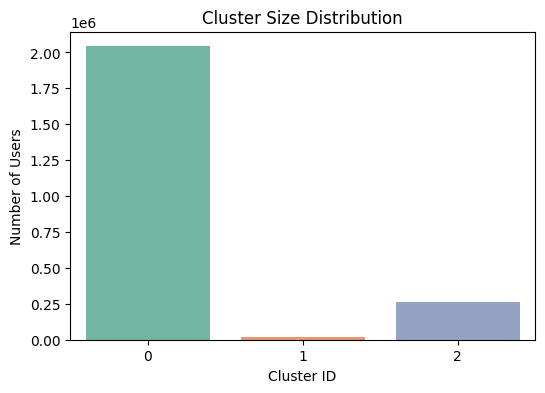

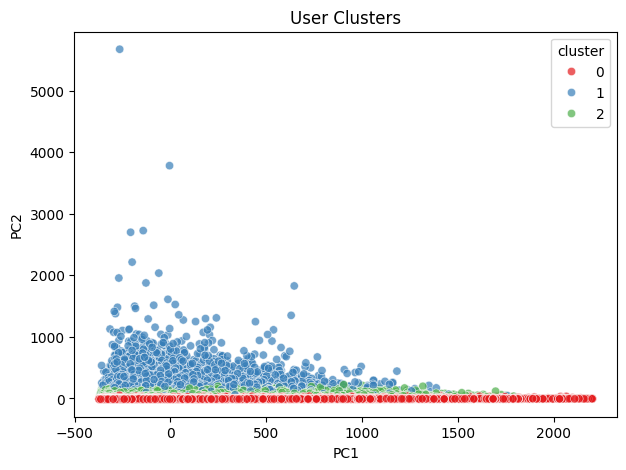

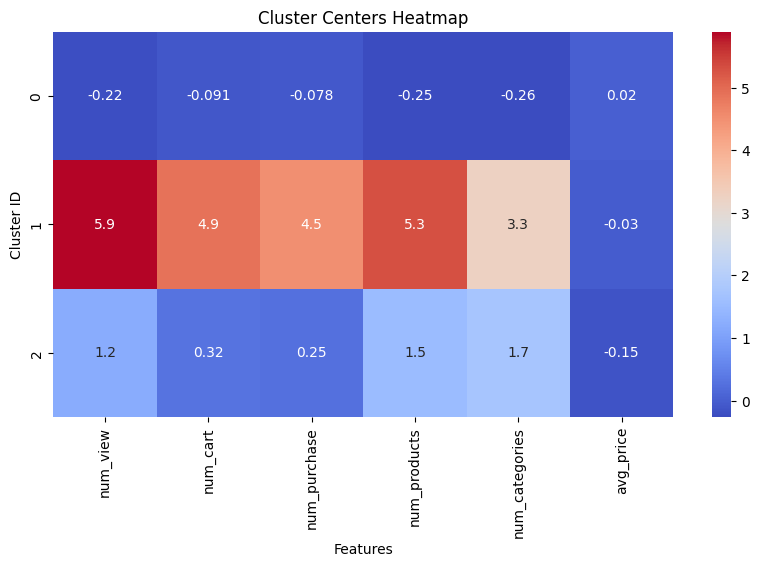

In [ ]:

#Converting the cluster components into pandas
#Converting into PCA components
#Heatmap is generated
from sklearn.decomposition import PCA
cluster_pdf = final_preds.select(
    "user_id", "cluster",
    "num_view", "num_cart", "num_purchase",
    "num_products", "num_categories", "avg_price"
).toPandas()


plt.figure(figsize=(6,4))
sns.countplot(data=cluster_pdf, x="cluster", palette="Set2")
plt.title("Cluster Size Distribution")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Users")
plt.show()

features = cluster_pdf[[
    "num_view", "num_cart", "num_purchase",
    "num_products", "num_categories", "avg_price"
]]

pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

cluster_pdf["PC1"] = pca_result[:,0]
cluster_pdf["PC2"] = pca_result[:,1]

plt.figure(figsize=(7,5))
sns.scatterplot(
    data=cluster_pdf,
    x="PC1", y="PC2",
    hue="cluster",
    palette="Set1",
    alpha=0.7
)
plt.title("User Clusters")
plt.show()

centers = np.array(final_model.clusterCenters())

plt.figure(figsize=(10,5))
sns.heatmap(
    centers,
    annot=True,
    cmap="coolwarm",
    xticklabels=cluster_features
)
plt.title("Cluster Centers Heatmap")
plt.xlabel("Features")
plt.ylabel("Cluster ID")
plt.show()


In [ ]:
#Adding a label for purchases, sampling to include 1% of the data, splitting into train/test.
#Encoding, Aseembling numeric values and training a logistic regression classifier
#Evaluating the model on test dataset and printing accuracy and F1 score.
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


data = df_clean.withColumn("label",F.when(F.col("event_type") == "purchase", 1).otherwise(0))
data = data.dropna(subset=["price", "category_code", "brand"])
sample_data = data.sample(0.01, seed=42)

train_data, test_data = sample_data.randomSplit([0.8, 0.2], seed=42)

categorical_cols = ["category_code", "brand"]
numeric_cols = ["price"]

indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_index", handleInvalid="keep") for c in categorical_cols]

encoder = OneHotEncoder(
    inputCols=[f"{c}_index" for c in categorical_cols],
    outputCols=[f"{c}_vec" for c in categorical_cols])

assembler = VectorAssembler(
    inputCols=numeric_cols + [f"{c}_vec" for c in categorical_cols],
    outputCol="features")


model = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=5)

pipeline = Pipeline(stages=indexers + [encoder, assembler, model])
fitted_model = pipeline.fit(train_data)

predictions = fitted_model.transform(test_data)

acc_eval = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy")

f1_eval = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1")

accuracy = acc_eval.evaluate(predictions)
f1_score = f1_eval.evaluate(predictions)

print("Accuracy:", accuracy)
print("F1 Score:", f1_score)

predictions.select("price", "category_code", "brand", "label", "prediction").show(10, truncate=False)


Accuracy: 0.9789093100331425
F1 Score: 0.968494984814116
+------+----------------------+-------+-----+----------+
|price |category_code         |brand  |label|prediction|
+------+----------------------+-------+-----+----------+
|128.3 |electronics.smartphone|meizu  |0    |0.0       |
|409.02|electronics.smartphone|samsung|0    |0.0       |
|370.64|electronics.smartphone|samsung|0    |0.0       |
|370.41|electronics.smartphone|samsung|0    |0.0       |
|370.41|electronics.smartphone|samsung|0    |0.0       |
|370.41|electronics.smartphone|samsung|0    |0.0       |
|370.41|electronics.smartphone|samsung|0    |0.0       |
|370.41|electronics.smartphone|samsung|0    |0.0       |
|370.64|electronics.smartphone|samsung|0    |0.0       |
|370.64|electronics.smartphone|samsung|0    |0.0       |
+------+----------------------+-------+-----+----------+
only showing top 10 rows



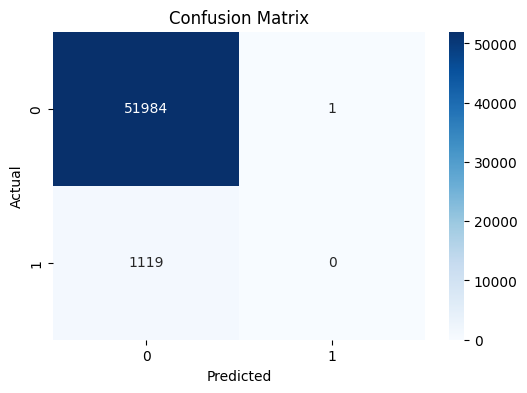

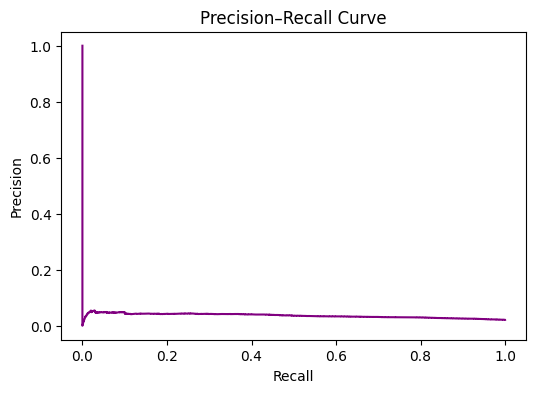

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     51985
           1       0.00      0.00      0.00      1119

    accuracy                           0.98     53104
   macro avg       0.49      0.50      0.49     53104
weighted avg       0.96      0.98      0.97     53104



In [ ]:
#Spark output is converted into Pandas
#Features converted into PCA components
#Precision and recall is calculated and classification report is produced.
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc

predictions = predictions.withColumn("prob_1",F.udf(lambda v: float(v[1]), "double")(predictions["rawPrediction"]))

pdf = predictions.select("label", "prediction", "prob_1").toPandas()

cm = confusion_matrix(pdf["label"], pdf["prediction"])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



precision, recall, _ = precision_recall_curve(pdf["label"], pdf["prob_1"])

plt.figure(figsize=(6,4))
plt.plot(recall, precision, color="purple")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()


print("Classification Report:")
print(classification_report(pdf["label"], pdf["prediction"]))

Accuracy: 0.9789093100331425
F1: 0.968494984814116
AUC: 0.6592463815651779


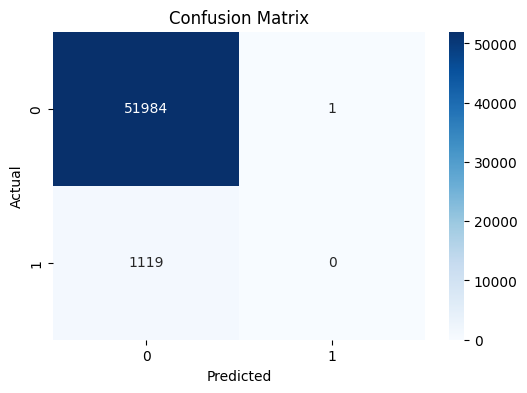

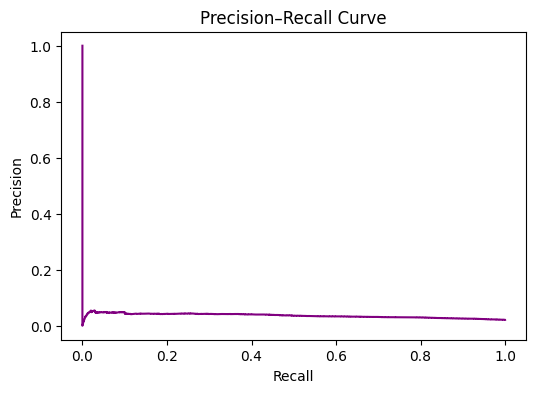

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     51985
           1       0.00      0.00      0.00      1119

    accuracy                           0.98     53104
   macro avg       0.49      0.50      0.49     53104
weighted avg       0.96      0.98      0.97     53104



In [ ]:
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report

labeled_df = df_clean.withColumn("label", F.when(F.col("event_type") == "purchase", 1).otherwise(0))
labeled_df = labeled_df.dropna(subset=["price", "category_code", "brand"])
sample_df = labeled_df.sample(0.01, seed=42)
train_df, test_df = sample_df.randomSplit([0.8, 0.2], seed=42)

categorical_cols = ["category_code", "brand"]
numeric_cols = ["price"]
index_stages = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in categorical_cols]
encoder = OneHotEncoder(
    inputCols=[f"{c}_idx" for c in categorical_cols],
    outputCols=[f"{c}_ohe" for c in categorical_cols]
)
assembler = VectorAssembler(
    inputCols=numeric_cols + [f"{c}_ohe" for c in categorical_cols],outputCol="features"
)
log_reg = LogisticRegression(featuresCol="features", labelCol="label", maxIter=5)

pipeline = Pipeline(stages=index_stages + [encoder, assembler, log_reg])
model = pipeline.fit(train_df)

predictions = model.transform(test_df)

acc_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
f1_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
auc_eval = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="probability", metricName="areaUnderROC")

print("Accuracy:", acc_eval.evaluate(predictions))
print("F1:", f1_eval.evaluate(predictions))
print("AUC:", auc_eval.evaluate(predictions))

prob_to_float = F.udf(lambda v: float(v[1]), DoubleType())
predictions = predictions.withColumn("prob_purchase", prob_to_float(F.col("probability")))
pdf = predictions.select("label", "prediction", "prob_purchase").toPandas()

plt.close('all')
cm = confusion_matrix(pdf["label"], pdf["prediction"])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

precision, recall, _ = precision_recall_curve(pdf["label"], pdf["prob_purchase"])
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color="purple")
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

print("Classification Report:")
print(classification_report(pdf["label"], pdf["prediction"]))
